In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "Adaptive RAG"

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

llm = ChatOllama(model="command-r:35b-v0.1-q5_K_M", format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are an expert at routing a user question to a vectorstore or web search. \n
    Use the vectorstore for questions on LLM  agents, prompt engineering, and adversarial attacks. \n
    You do not need to be stringent with the keywords in the question related to these topics. \n
    Otherwise, use web-search. Give a binary choice 'web_search' or 'vectorstore' based on the question. \n
    Return the a JSON with a single key 'datasource' and no premable or explanation. \n
    Question to route: {question}""",
    input_variables=["question"],
)
question_router = prompt | llm | JsonOutputParser()
question = "llm agent memory"
print(question_router.invoke({"question": question}))

{'datasource': 'vectorstore'}


In [6]:
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_text = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_text}))

/Users/admin/miniconda3/envs/langgraph/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


{'score': 'yes'}


In [7]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

llm = ChatOllama(model="command-r:35b-v0.1-q5_K_M", temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

#Chain
rag_chain = prompt | llm | StrOutputParser()   

question = "agent memory"
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)   

Agents have both short-term and long-term memory. Short-term memory is restricted by the finite context window length of Transformers, while long-term memory is an external database that can be accessed for infinite information retrieval. Memory also involves different mechanisms like sensory memory for raw inputs and planning & reacting to translate reflections into actions.


In [8]:
### Hallucination Grader

#LLM
llm = ChatOllama(model="command-r:35b-v0.1-q5_K_M", format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [9]:
### Answer Grader

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

In [11]:
### Question Re-writer


# Prompt
re_write_prompt = PromptTemplate(
    template="""You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the initial and formulate an improved question. \n
     Here is the initial question: \n\n {question}. Improved question with no preamble: \n """,
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'{ "query": "past interactions stored in agent\'s memory?" }'

In [12]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [14]:
# State
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """Represents the state of the graph."""

    question: str
    generation: str
    documents: List[str]

In [18]:
### Nodes
from pprint import pprint

from langchain.schema import Document

def retrieve(state):
    """Retrieve documents based on a question."""
    print("---Retrieving---")
    question=state['question']

    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

def generate(state):
    """Generate an answer based on a question and a set of documents."""
    print("---Generating---")
    question=state['question']
    documents=state['documents']

    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"document": documents, "question": question, "generation": generation}

def grade_documents(state):
    """Grade the relevance of a document to a question."""
    print("---Grading---")
    question=state['question']
    documents=state['documents']

    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT IRRELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """Transform a question for better retrieval."""
    print("---Transforming---")
    question=state['question']
    documents=state['documents']

    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """Web search based on the re-phrased question."""

    print("---Web Searching---")
    question=state['question']

    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

### Edges

def route_question(state):
    """Route a question to either the vectorstore or web search."""
    print("---Routing---")
    question=state['question']
    print(question)
    source = question_router.invoke({"question": question})
    if source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    
def decide_to_generate(state):
    """Determines whether to generate an answer, or re-generate a question"""

    print("----Assessing Graded Documents----")
    filtered_docs = state['documents']

    if not filtered_docs:
        print("---NO RELEVANT DOCUMENTS---")
        return "transform_query"
    else:
        print("---RELEVANT DOCUMENTS---")
        return "generate"
    
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [20]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

workflow.add_conditional_edges(
    START,
    route_question, 
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    }
)

app = workflow.compile()

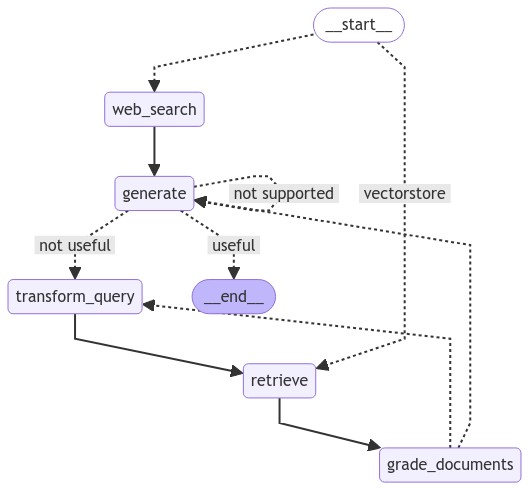

In [21]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
from pprint import pprint

# Run
inputs = {"question": "What is the AlphaCodium paper about?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---Routing---
What is the AlphaCodium paper about?
---ROUTE QUESTION TO WEB SEARCH---
---Web Searching---
"Node 'web_search':"
'\n---\n'
---Generating---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
("The paper introduces AlphaCodium, a groundbreaking approach to enhance LLMs' "
 "performance on code generation problems. It's a test-based, multi-stage "
 'process, improving accuracy and addressing the unique challenges of coding '
 'tasks. The method was tested on the CodeContests dataset, achieving '
 'impressive results.')
